In [2]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm
from matplotlib import cm
from matplotlib.ticker import LinearLocator

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201

In [3]:
class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.network(x)

In [4]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

$$
y'' + 2y' + 10y = 0 \\
y(0) = y_0, \quad y'(0) = y_1
$$

In [5]:
def second_order(t, y):
    return np.array([[0.0, 1.0], [-10.0, -2.0]]) @ y


def solve_second_order(t_span, y0, y_t0):
    return

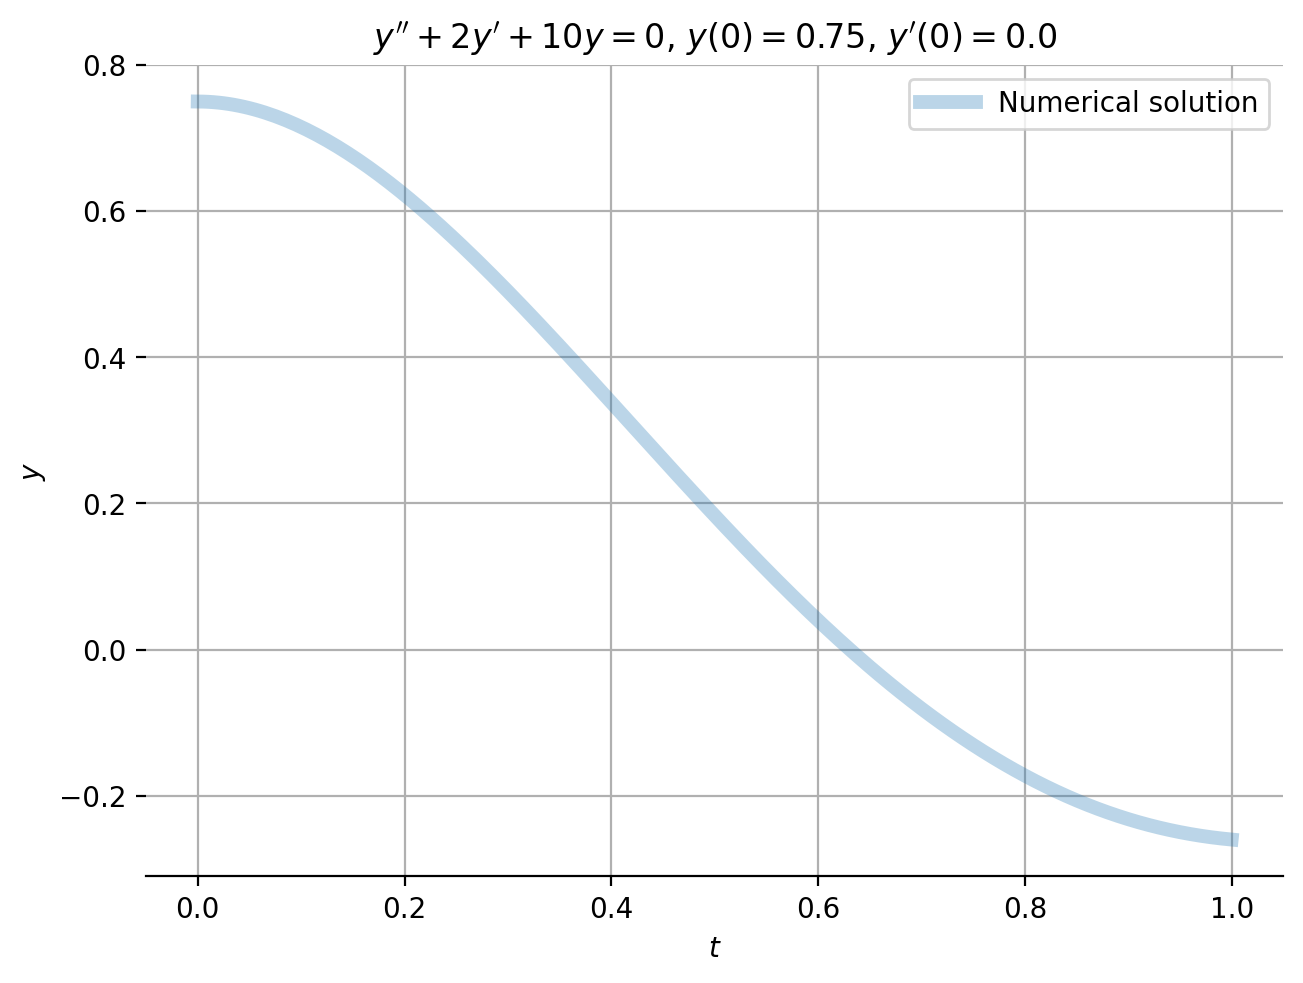

In [14]:

domain = (0.0, 1.0)
t_0=0.0
y0 = 0.75
y_t0 = 0.0

t_dense = np.linspace(*domain, n_dense_points)

second_order_sol = integrate.solve_ivp(
    second_order, domain, (y0, y_t0), dense_output=True
)
y_numerical = second_order_sol.sol(t_dense)

fig, ax = plt.subplots()
ax.plot(
    t_dense,
    y_numerical[0],
    c="C0",
    linewidth=5,
    alpha=0.3,
    label="Numerical solution",
)
ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$",
    title=rf"$y'' + 2y' + 10y = 0$, $y(0) = {y0}$, $y'(0) = {y_t0}$",
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

In [15]:
torch.manual_seed(78)
batch_size = 10000
n_epochs = 1_000
print_interval = n_epochs // 10
learning_rate = 0.01

model = MLP(1, 16, 32, 1)
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history=[]

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = model(t)
    y_e=torch.exp(-t)*(3/4*torch.cos(3*t)+1/4*torch.sin(3*t))
    y_t = grad(y, t)
    y_tt = grad(y_t, t)

    t0 = torch.zeros(1, 1).requires_grad_()
    y0_pred = model(t0)
    y_t0_pred = grad(y0_pred, t0)

    # Loss
    loss_de = F.mse_loss(y_tt + 2.0 * y_t + 10.0 * y, torch.zeros_like(y_tt))
    loss_bc = (
        F.mse_loss(y0_pred, torch.tensor([[y0]]))
        + F.mse_loss(y_t0_pred, torch.tensor([[y_t0]]))
    )
    loss = loss_de + loss_bc
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))**0.5


    # Backprop
    loss.backward()
    loss = loss_de**0.5+F.mse_loss(y0_pred, torch.tensor([[y0]]))**0.5+ F.mse_loss(y_t0_pred, torch.tensor([[y_t0]]))**0.5
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())

    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_bc = {loss_bc.item():.4f}, loss_de = {loss_de.item():.4f}, loss = {loss.item():.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_bc = 0.3829, loss_de = 11.0332, loss = 4.1325
epoch = 100, loss_bc = 0.5004, loss_de = 0.0263, loss = 0.9563
epoch = 200, loss_bc = 0.5010, loss_de = 0.0249, loss = 0.9524
epoch = 300, loss_bc = 0.5009, loss_de = 0.0264, loss = 0.9570
epoch = 400, loss_bc = 0.5009, loss_de = 0.0257, loss = 0.9546
epoch = 500, loss_bc = 0.5009, loss_de = 0.0257, loss = 0.9546
epoch = 600, loss_bc = 0.5009, loss_de = 0.0254, loss = 0.9536
epoch = 700, loss_bc = 0.5009, loss_de = 0.0263, loss = 0.9565
epoch = 800, loss_bc = 0.5009, loss_de = 0.0254, loss = 0.9537
epoch = 900, loss_bc = 0.5009, loss_de = 0.0256, loss = 0.9544


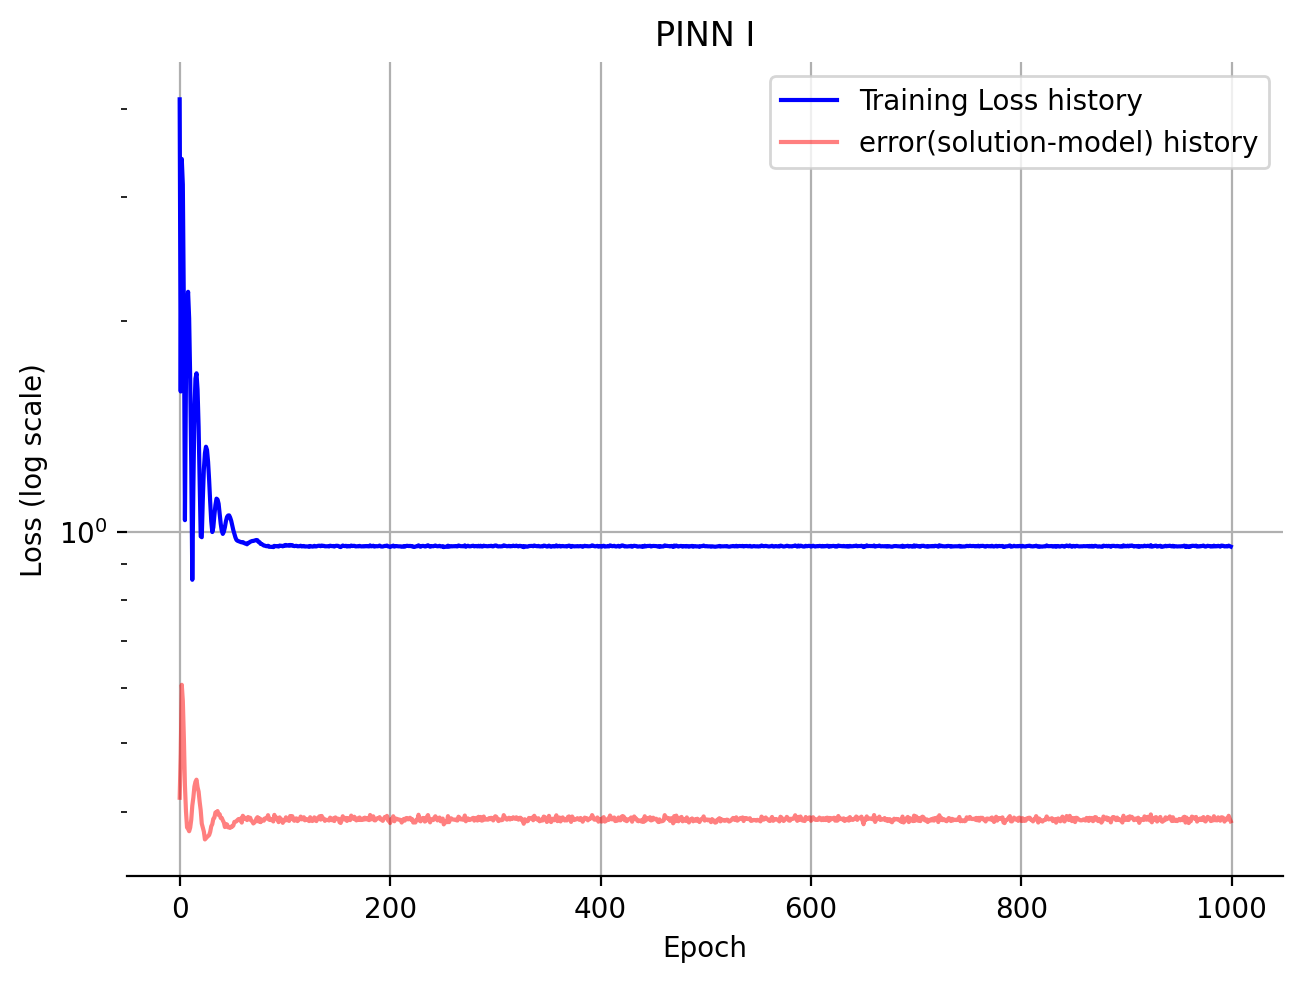

In [8]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN I"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [9]:
X=np.array(loss_history)
Y=np.array(realloss_history)

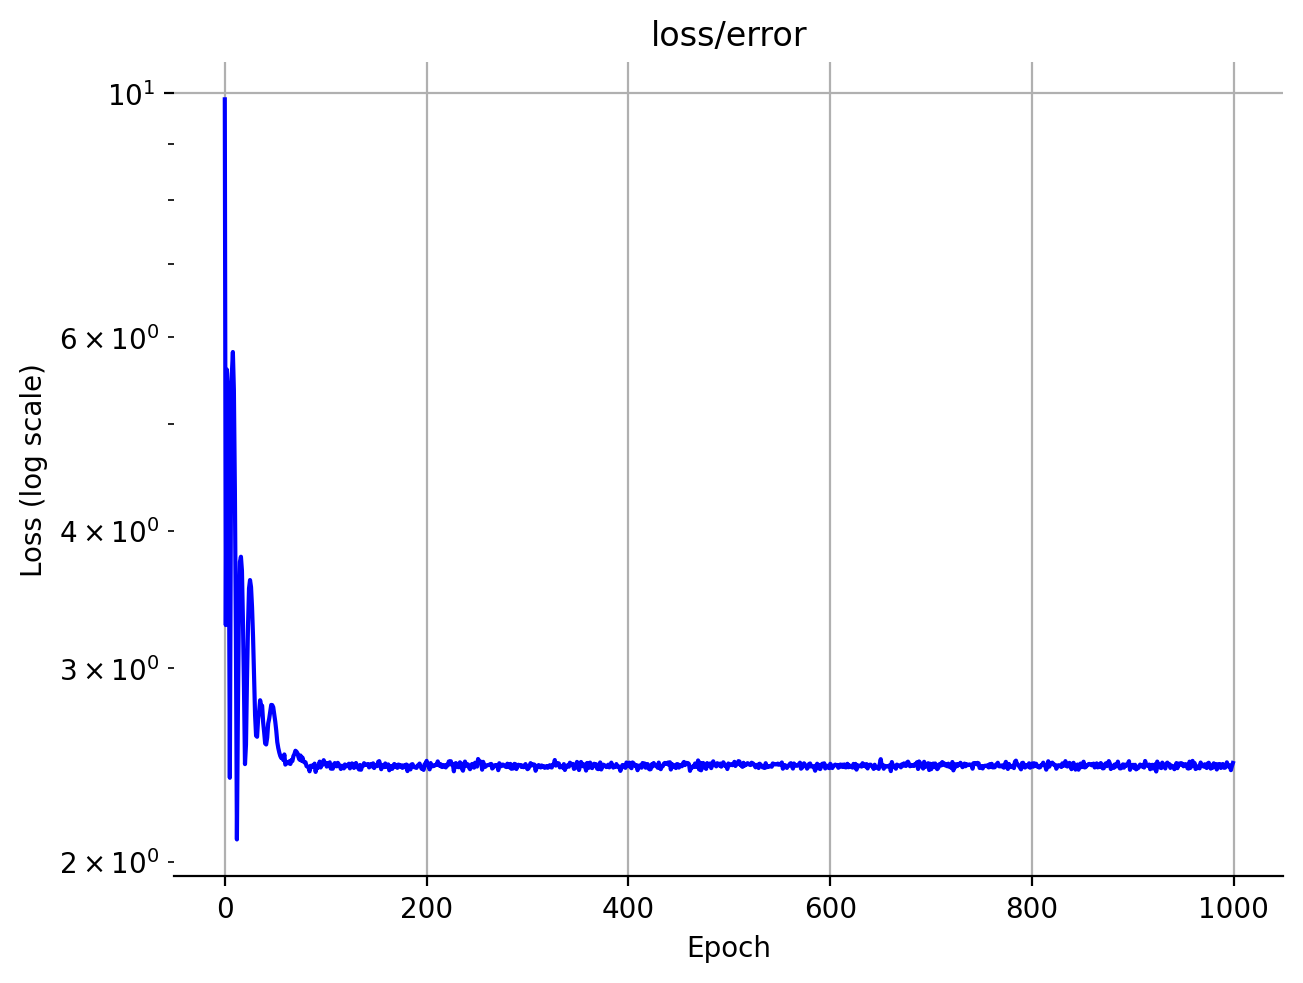

In [10]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

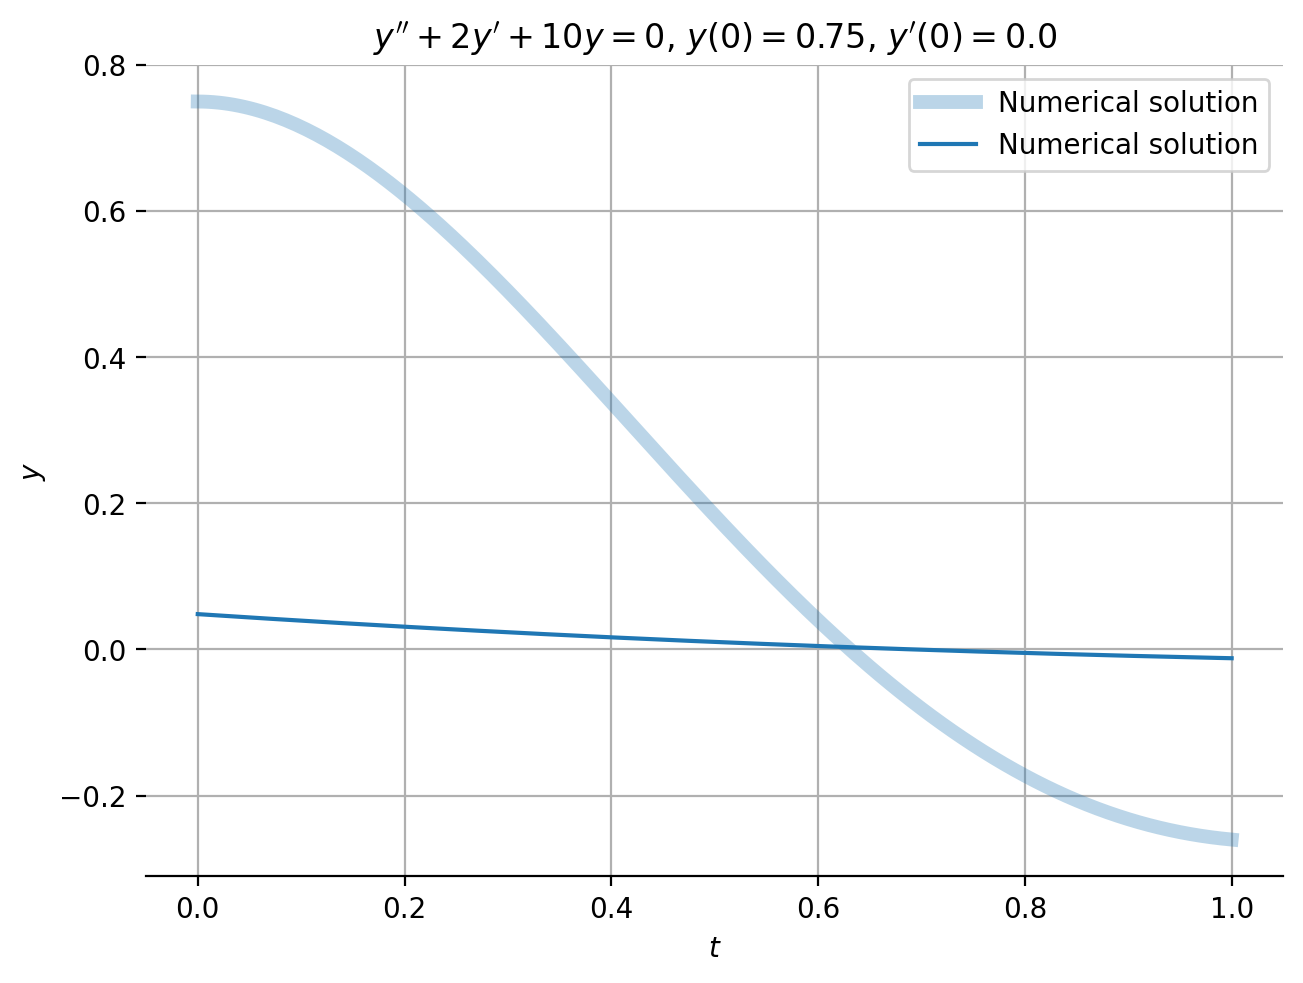

In [11]:
domain = (0.0, 1.0)
t_0=0.0
y0 = 0.75
y_t0 = 0.0

t_dense = np.linspace(*domain, n_dense_points)
t = torch.tensor(t_dense, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y = model(t)

fig, ax = plt.subplots()

ax.plot(t_dense,np.exp(-1*t_dense)*(3/4*np.cos(3*t_dense)+1/4*np.sin(3*t_dense)),c="C0",linewidth=5,alpha=0.3,label="Numerical solution")
ax.plot(t_dense,y,c="C0",label="Numerical solution")

ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$",
    title=rf"$y'' + 2y' + 10y = 0$, $y(0) = {y0}$, $y'(0) = {y_t0}$",
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

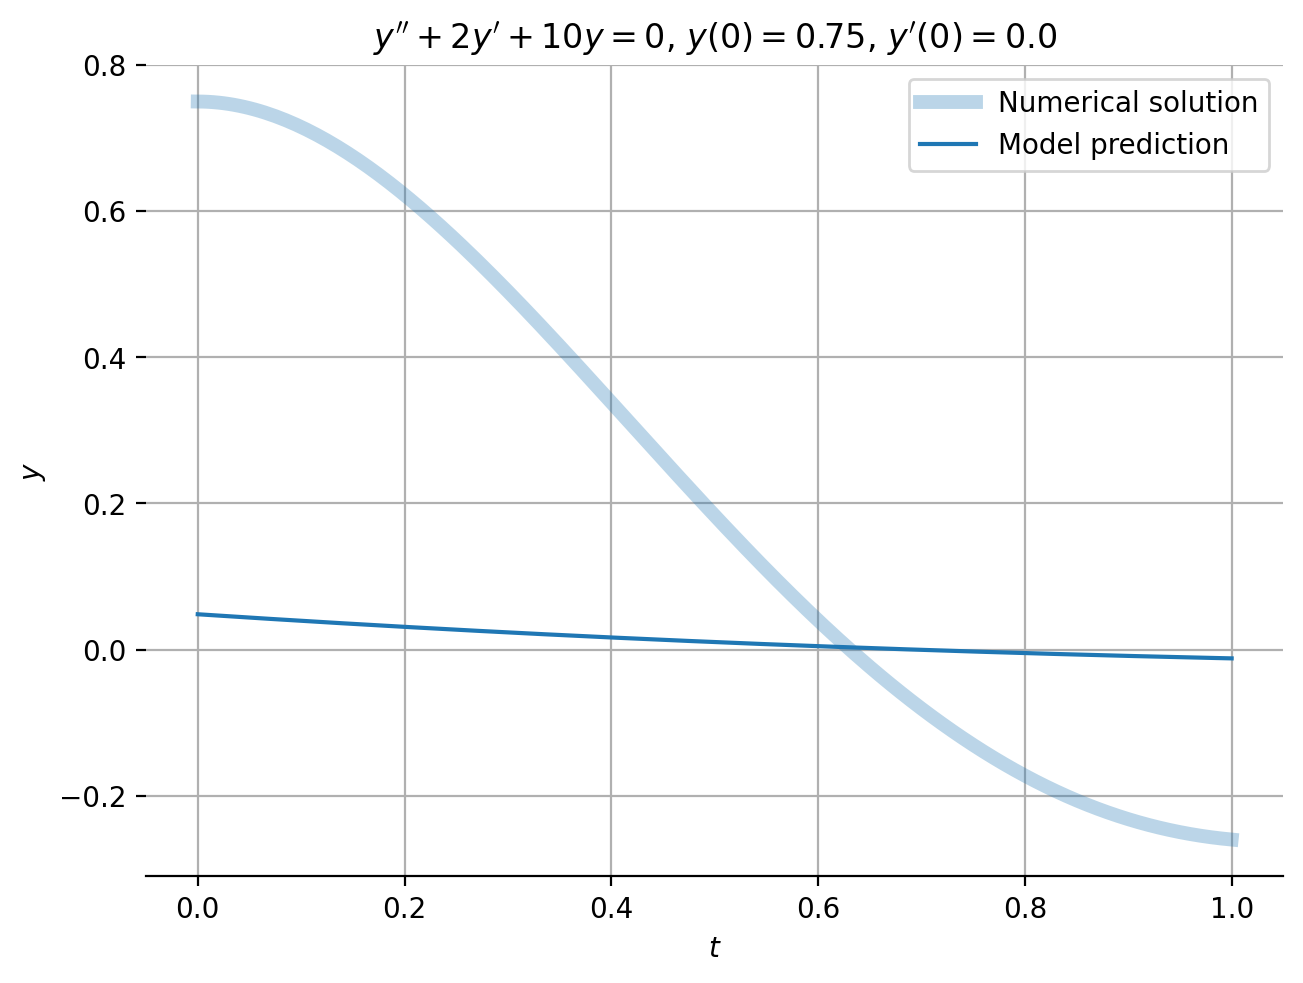

In [12]:
t = torch.tensor(t_dense, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y = model(t)
fig, ax = plt.subplots()
ax.plot(
    t_dense,
    y_numerical[0],
    c="C0",
    linewidth=5,
    alpha=0.3,
    label="Numerical solution",
)
ax.plot(t, y, c="C0", label="Model prediction")
ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$",
    title=rf"$y'' + 2y' + 10y = 0$, $y(0) = {y0}$, $y'(0) = {y_t0}$",
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

In [16]:
torch.manual_seed(78)
batch_size = 10000
n_epochs = 1_000
print_interval = n_epochs // 10
learning_rate = 0.01

model = MLP(1, 16, 32, 1)
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history = []

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = (t**2)*model(t)+t*y_t0+y0
    y_t = grad(y, t)
    y_tt = grad(y_t, t)
    y_e=torch.exp(-t)*(3/4*torch.cos(3*t)+1/4*torch.sin(3*t))


    t0 = torch.zeros(1, 1).requires_grad_()

    # Loss
    loss_de = F.mse_loss(y_tt + 2.0 * y_t + 10.0 * y, torch.zeros_like(y_tt))

    loss = loss_de
    realloss = F.mse_loss(y-y_e, torch.zeros_like(y))**0.5

    # Backprop
    loss.backward()
    loss = loss_de**0.5
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss = {loss.item():.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 112.0422, loss = 10.5850
epoch = 100, loss_de = 1.9967, loss = 1.4131
epoch = 200, loss_de = 1.5545, loss = 1.2468
epoch = 300, loss_de = 1.6013, loss = 1.2654
epoch = 400, loss_de = 1.5534, loss = 1.2464
epoch = 500, loss_de = 1.5585, loss = 1.2484
epoch = 600, loss_de = 1.5427, loss = 1.2421
epoch = 700, loss_de = 1.5938, loss = 1.2625
epoch = 800, loss_de = 1.5457, loss = 1.2433
epoch = 900, loss_de = 1.5532, loss = 1.2463


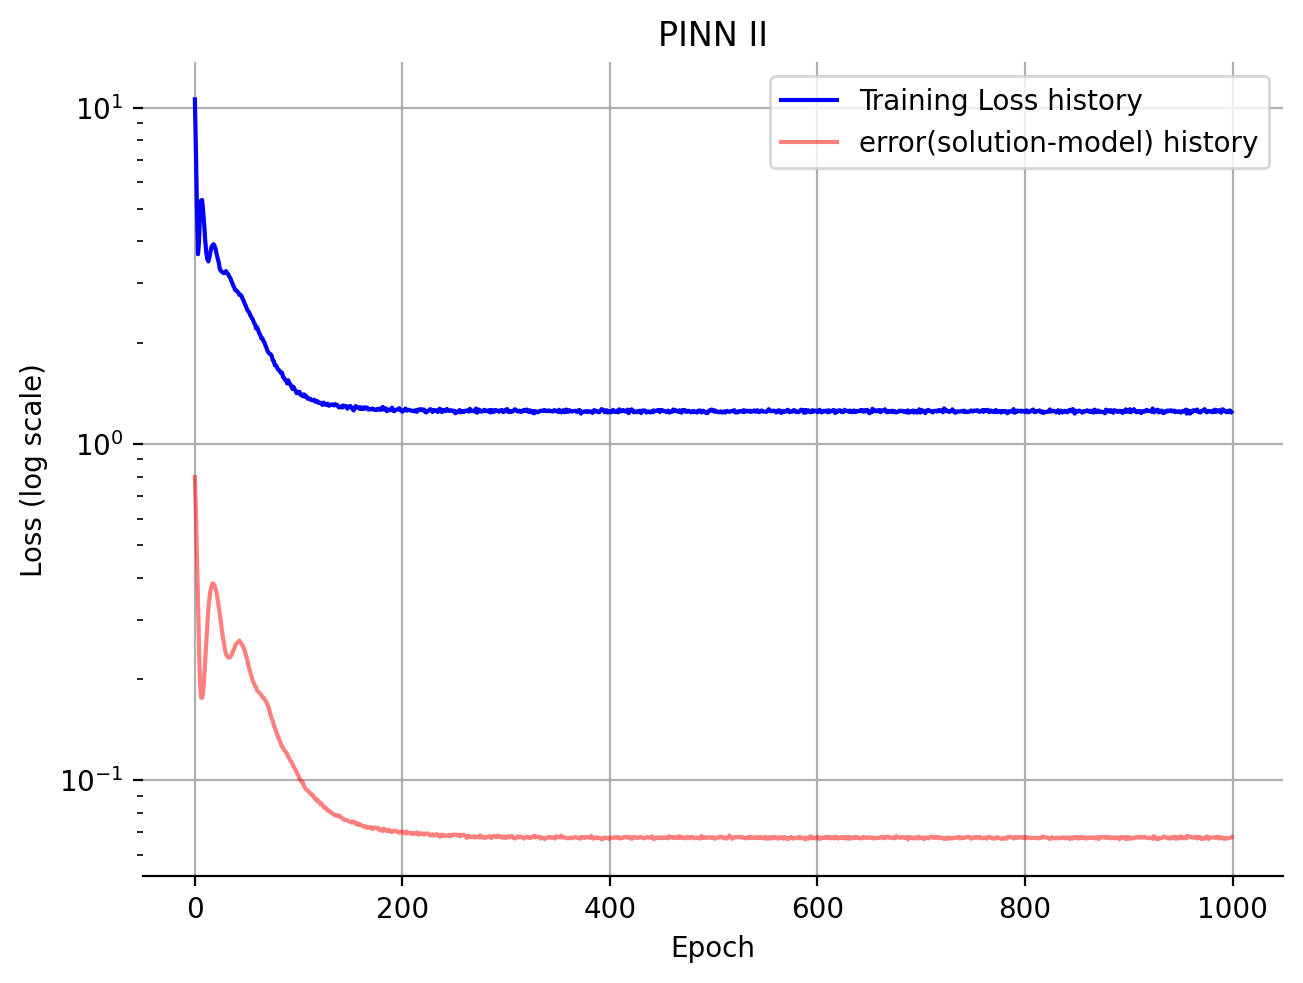

In [17]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN II"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [18]:
X=np.array(loss_history)
Y=np.array(realloss_history)

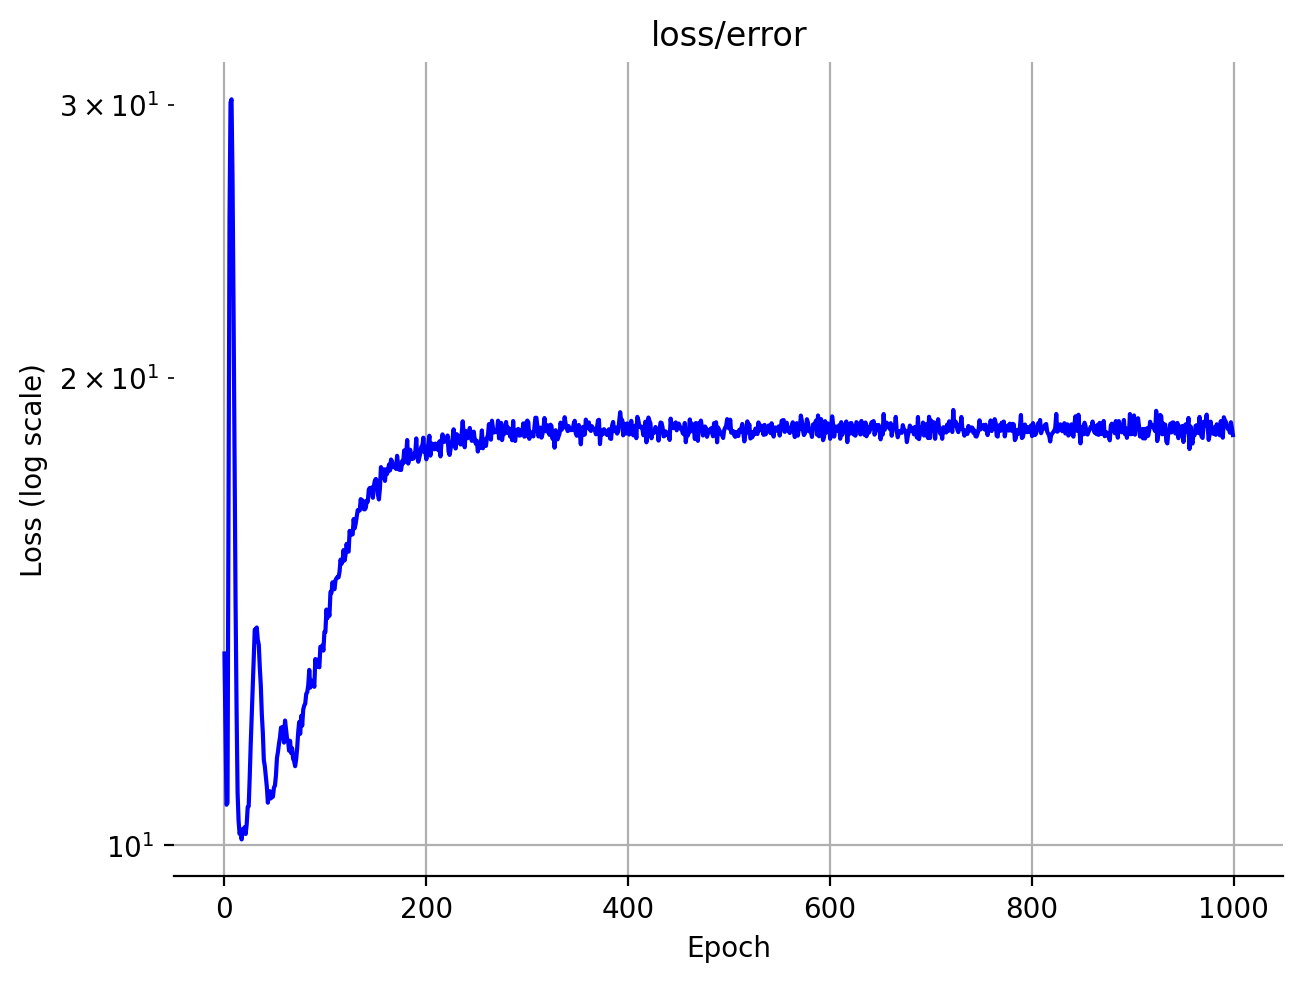

In [19]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

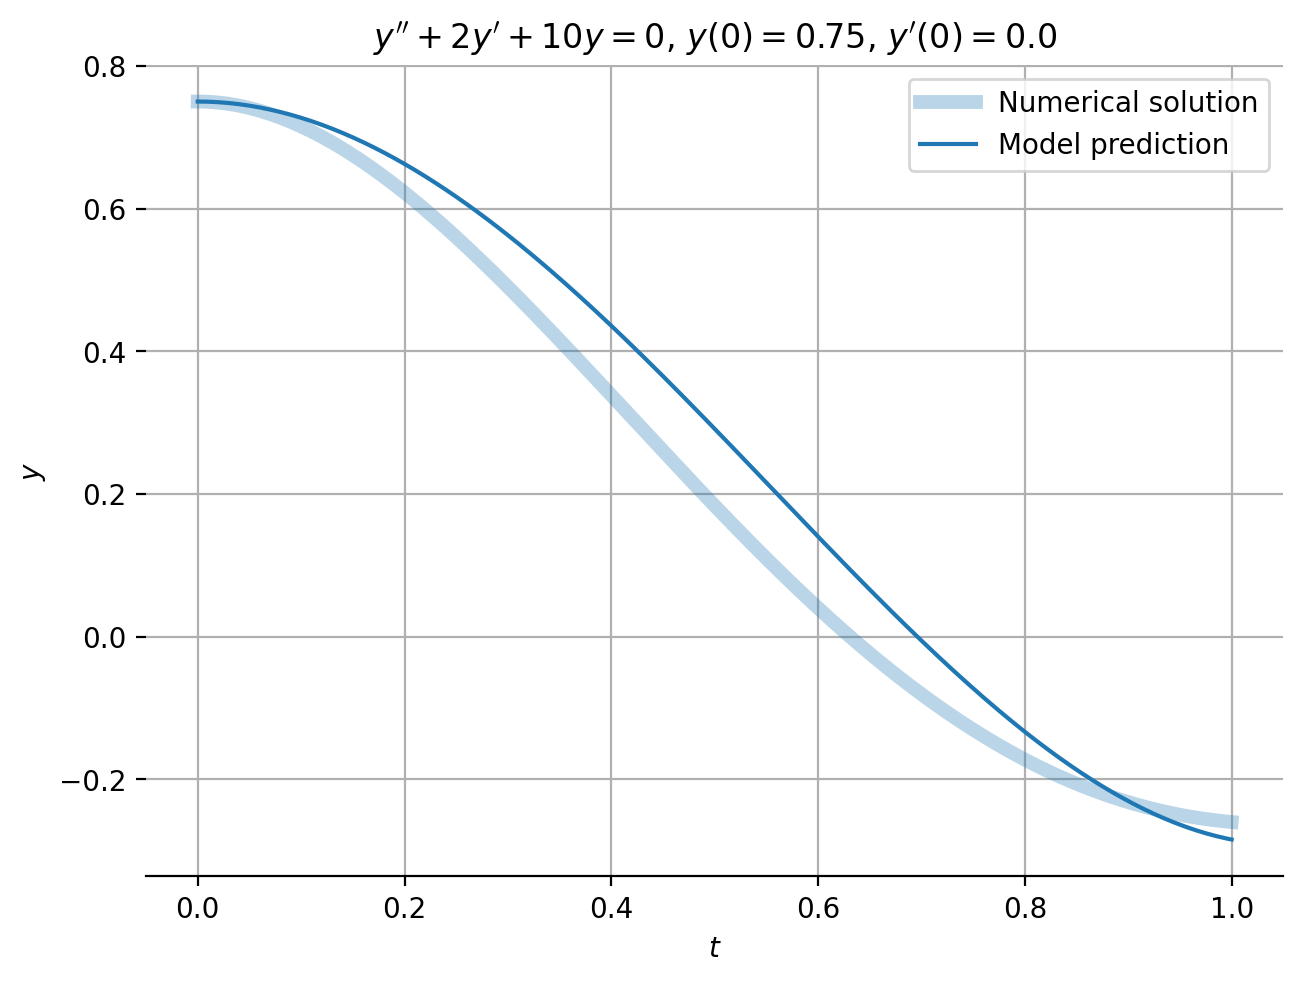

In [20]:
t = torch.tensor(t_dense, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y = (t**2)*model(t)+t*y_t0+y0
fig, ax = plt.subplots()
ax.plot(
    t_dense,
    y_numerical[0],
    c="C0",
    linewidth=5,
    alpha=0.3,
    label="Numerical solution",
)
ax.plot(t, y, c="C0", label="Model prediction")
ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$",
    title=rf"$y'' + 2y' + 10y = 0$, $y(0) = {y0}$, $y'(0) = {y_t0}$",
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass